In [1]:
!pip install lightgbm

In [2]:
%pip install -U imbalanced-learn

In [3]:
!pip show imbalanced-learn

Name: imbalanced-learn
Version: 0.14.0
Summary: Toolbox for imbalanced dataset in machine learning
Home-page: https://imbalanced-learn.org/
Author: 
Author-email: "G. Lemaitre" <g.lemaitre58@gmail.com>, "C. Aridas" <ichkoar@gmail.com>
License: 
Location: C:\Users\XELFMARS\anaconda3\Lib\site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 


In [1]:
# Data set libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint
#Model libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

from sklearn.multioutput import MultiOutputClassifier

from imblearn.pipeline import Pipeline as ImbPipeline

In [2]:
# Load the dataset
df = pd.read_csv(r"C:\Users\XELFMARS\Documents\TC PROJECT\ai4i2020_with_features.csv")
df.head(10)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,TempDiff,Power [W],OverstrainMetric
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6951.590560,0.0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6826.722724,138.9
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,7749.387543,247.0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,5927.504659,276.5
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,5897.816608,360.0
5,6,M14865,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0,10.5,6252.554779,460.9
6,7,L47186,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0,10.5,6917.703247,593.6
7,8,L47187,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0,10.5,6428.264056,643.2
8,9,M14868,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0,10.4,4992.639989,514.8
9,10,M14869,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0,10.5,5104.878623,588.0


In [8]:
# Let us check for inconsistent columns, i.e columns where a machine failure was said to occur with any specific failure type happening

# Define the specific, known failure types
specific_failure_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Condition 1: The machine *did* fail
mac_failed = (df['Machine failure'] == 1)

# Condition 2: *None* of the specific failure types are flagged
# We check if *all* of them are 0.
mac_no_reason = (df[specific_failure_cols] == 0).all(axis=1)

# Combine the masks to find the problem rows
unattributed_mac = mac_failed & mac_no_reason

# Use the mask to *see* the problem rows
unattributed_rows = df[unattributed_mac]

print(f"Found {len(unattributed_rows)} unattributed failure rows.")


Found 9 unattributed failure rows.


In [9]:
unattributed_rows
#these are the 9 inconsistent rows we have

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,TempDiff,Power [W],OverstrainMetric
1437,1438,H30851,H,298.8,309.9,1439,45.2,40,1,0,0,0,0,0,11.1,6811.266088,1808.0
2749,2750,M17609,M,299.7,309.2,1685,28.9,179,1,0,0,0,0,0,9.5,5099.485555,5173.1
4044,4045,M18904,M,301.9,310.9,1419,47.7,20,1,0,0,0,0,0,9.0,7088.092761,954.0
4684,4685,M19544,M,303.6,311.8,1421,44.8,101,1,0,0,0,0,0,8.2,6666.543387,4524.8
5536,5537,M20396,M,302.3,311.8,1363,54.0,119,1,0,0,0,0,0,9.5,7707.583416,6426.0
5941,5942,L53121,L,300.6,310.7,1438,48.5,78,1,0,0,0,0,0,10.1,7303.469881,3783.0
6478,6479,L53658,L,300.5,309.8,1663,29.1,145,1,0,0,0,0,0,9.3,5067.734525,4219.5
8506,8507,L55686,L,298.4,309.6,1710,27.3,163,1,0,0,0,0,0,11.2,4888.632328,4449.9
9015,9016,L56195,L,297.2,308.1,1431,49.7,210,1,0,0,0,0,0,10.9,7447.742288,10437.0


In [10]:

# The ~ operator selects all rows that are *NOT* in the mask
clean_df = df[~unattributed_mac].copy()

# 3. Verify the operation
print(f"\nOriginal DataFrame shape: {df.shape}")
print(f"Cleaned DataFrame shape:  {clean_df.shape}")
print(f"Total rows removed:       {len(df) - len(clean_df)}")


Original DataFrame shape: (10000, 17)
Cleaned DataFrame shape:  (9991, 17)
Total rows removed:       9


In [11]:
clean_df.shape

(9991, 17)

In [12]:
# Drop 'Product ID' and 'UDI' as they are likely identifiers and not useful features
cols_to_drop = ['UDI','Product ID']
df_clean = clean_df.drop(columns=cols_to_drop)
df_clean.head(10)

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,TempDiff,Power [W],OverstrainMetric
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6951.590560,0.0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6826.722724,138.9
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,7749.387543,247.0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,5927.504659,276.5
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,5897.816608,360.0
5,M,298.1,308.6,1425,41.9,11,0,0,0,0,0,0,10.5,6252.554779,460.9
6,L,298.1,308.6,1558,42.4,14,0,0,0,0,0,0,10.5,6917.703247,593.6
7,L,298.1,308.6,1527,40.2,16,0,0,0,0,0,0,10.5,6428.264056,643.2
8,M,298.3,308.7,1667,28.6,18,0,0,0,0,0,0,10.4,4992.639989,514.8
9,M,298.5,309.0,1741,28.0,21,0,0,0,0,0,0,10.5,5104.878623,588.0


In [13]:
df_clean.shape

(9991, 15)

## BUILD BINARY MODEL TO PREDICT MACHINE FAILURE ONLY

In [14]:
#Define the X and y variables
X = df_clean.drop(columns=['Machine failure','TWF', 'HDF', 'PWF', 'OSF', 'RNF'])
y = df_clean['Machine failure']

In [15]:
#Encode the only categorical column in X
le=LabelEncoder()
X['Type']=le.fit_transform(X['Type'])
X

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TempDiff,Power [W],OverstrainMetric
0,2,298.1,308.6,1551,42.8,0,10.5,6951.590560,0.0
1,1,298.2,308.7,1408,46.3,3,10.5,6826.722724,138.9
2,1,298.1,308.5,1498,49.4,5,10.4,7749.387543,247.0
3,1,298.2,308.6,1433,39.5,7,10.4,5927.504659,276.5
4,1,298.2,308.7,1408,40.0,9,10.5,5897.816608,360.0
...,...,...,...,...,...,...,...,...,...
9995,2,298.8,308.4,1604,29.5,14,9.6,4955.129373,413.0
9996,0,298.9,308.4,1632,31.8,17,9.5,5434.703963,540.6
9997,2,299.0,308.6,1645,33.4,22,9.6,5753.617506,734.8
9998,0,299.0,308.7,1408,48.5,25,9.7,7151.102638,1212.5


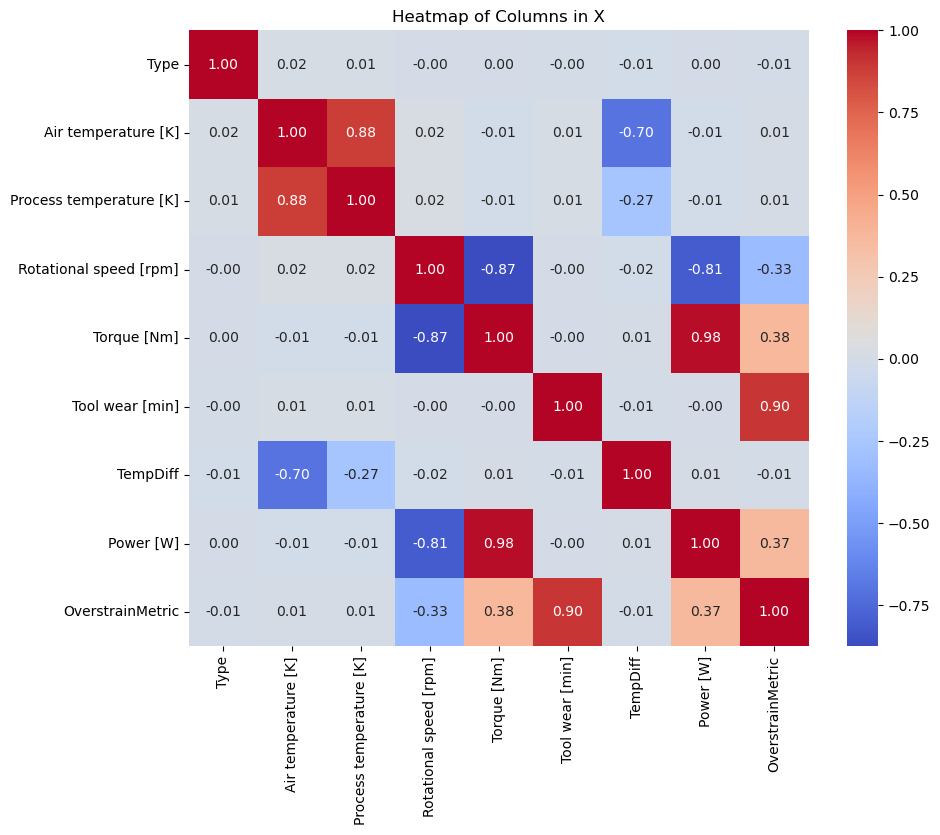

In [16]:
#CHECK FOR MULTICOLINEARITY
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Columns in X')
plt.show()

Multicolinearity affects linear models greatly, so highly correlateted variables must be drop when using linear models

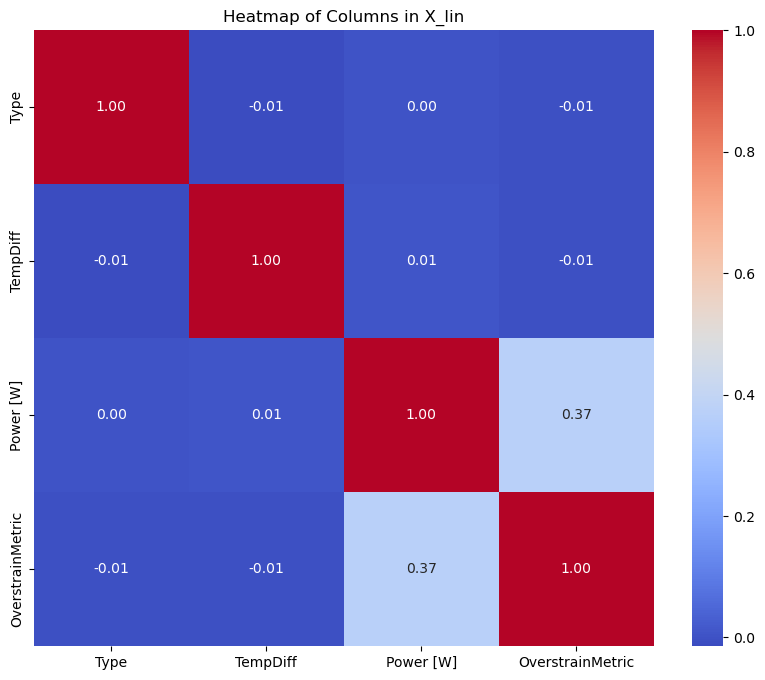

In [17]:
X_lin = df_clean.drop(columns=['Machine failure','TWF', 'HDF', 'PWF', 'OSF', 'RNF','Air temperature [K]','Process temperature [K]','Rotational speed [rpm]','Tool wear [min]','Torque [Nm]'])
#This gets rid of the highly correlated variables and builds a stronger overall model for our logistics classifier

#Encode the only categorical column in X_lin
le=LabelEncoder()
X_lin['Type']=le.fit_transform(X_lin['Type'])
X_lin

#CHECK FOR MULTICOLINEARITY
plt.figure(figsize=(10, 8))
sns.heatmap(X_lin.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap of Columns in X_lin')
plt.show()

In [18]:
X_lin

,Type,TempDiff,Power [W],OverstrainMetric
0,2,10.5,6951.590560,0.0
1,1,10.5,6826.722724,138.9
2,1,10.4,7749.387543,247.0
3,1,10.4,5927.504659,276.5
4,1,10.5,5897.816608,360.0
...,...,...,...,...
9995,2,9.6,4955.129373,413.0
9996,0,9.5,5434.703963,540.6
9997,2,9.6,5753.617506,734.8
9998,0,9.7,7151.102638,1212.5


In [19]:
#Implement Train-Test Split 1st
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_lin_train, X_lin_test, y_train, y_test= train_test_split(X_lin, y, test_size=0.2, random_state=42, stratify=y)

In [178]:
#Feature scaling
scaler_lr = StandardScaler()
scaler_rf = StandardScaler()

X_train_scaled = scaler_rf.fit_transform(X_train)
X_test_scaled = scaler_rf.transform(X_test)
X_lin_train_scaled = scaler_lr.fit_transform(X_lin_train)
X_lin_test_scaled = scaler_lr.transform(X_lin_test)

In [179]:
#Create prelim model as a baseline without imbalance fix or hyperparam tuning
#Logistics Regression
lr = LogisticRegression()
lr.fit(X_lin_train_scaled, y_train)

LogisticRegression()

In [180]:
#RandomForest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [181]:
#XGBoost
boost=XGBClassifier(random_state=42)
boost.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [182]:
#TO PREDICT WITH THE MODELS
y_lr_pred=lr.predict(X_lin_test_scaled)
y_rf_pred=rf.predict(X_test_scaled)
y_boost_pred=boost.predict(X_test_scaled)

In [183]:
y_boost_pred.shape

(1999,)

In [184]:
print('Logistic Regression')
print(classification_report(y_test, y_lr_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_lr_pred))

print('\nRandom Forest')
print(classification_report(y_test, y_rf_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_rf_pred))

print('\nXGBoost')
print(classification_report(y_test, y_boost_pred))
print('Confusion matrix:\n', confusion_matrix(y_test, y_boost_pred))

Logistic Regression
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1933
           1       1.00      0.05      0.09        66

    accuracy                           0.97      1999
   macro avg       0.98      0.52      0.54      1999
weighted avg       0.97      0.97      0.95      1999

Confusion matrix:
 [[1933    0]
 [  63    3]]

Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.95      0.91      0.93        66

    accuracy                           1.00      1999
   macro avg       0.97      0.95      0.96      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix:
 [[1930    3]
 [   6   60]]

XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.91      0.91      0.91        66

    accuracy                           0.99   

In [27]:
#The absurdly high rate of false negatives and very low recall and f1 score reflect the effect of the imbalanced data on the Logistics Regression Model
#This scores should improve with class weights and hypertuning

### CLASS IMBALANCE AND HYPERPARAMETER TUNING FOR BINARY MODEL

In [28]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [29]:
#Now to address the class imbalance and hypertuning
#using class weights and hyperparam tuning

#LOGISTICS REGRESSOR
log = LogisticRegression(class_weight='balanced')

param_dist={'C': uniform(0.01, 100), 'max_iter' :randint(50,2000), 'penalty': ['l1', 'l2'], 'solver':['liblinear']}
rand_search=RandomizedSearchCV(estimator=log, param_distributions=param_dist, n_iter=50,cv=5,scoring='f1_macro',random_state=42,n_jobs=-1)
rand_search.fit(X_lin_train_scaled, y_train)


RandomizedSearchCV(cv=5, estimator=LogisticRegression(class_weight='balanced'),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF11CCBB60>,
                                        'max_iter': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF14CAF770>,
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['liblinear']},
                   random_state=42, scoring='f1_macro')

In [30]:
print(rand_search.best_params_)

{'C': np.float64(37.464011884736244), 'max_iter': 910, 'penalty': 'l1', 'solver': 'liblinear'}


In [31]:
Tuned_model=rand_search.best_estimator_
y_lr_tuned=Tuned_model.predict(X_lin_test_scaled)

In [32]:
print('Logistic Regression')
print(classification_report(y_test,y_lr_tuned))
print('Confusion matrix:\n', confusion_matrix(y_test, y_lr_tuned))

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.75      0.85      1933
           1       0.09      0.73      0.16        66

    accuracy                           0.74      1999
   macro avg       0.54      0.74      0.50      1999
weighted avg       0.96      0.74      0.83      1999

Confusion matrix:
 [[1441  492]
 [  18   48]]


The poor performance of the log regression model on the no failure class (high false positives) is likely due to the fact that log reg is restrictive due to the multicolinearity dilema, we are forced to remove some of the columns needed to find some specific failure type(i.e TWF which needs tool wear)  due to multicolinearity
and we just can't remove the engineered columns as that would make log reg blind to HDF PWF and OSF because a linear model is very bad at learning "interaction" rules on its own.

We have to focus on tree based models to fix these issues

In [33]:
from IPython.display import display
from tqdm.notebook import tqdm
import sys
sys.stdout.flush()

In [34]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [35]:
#RANDOM FOREST MODEL WITH TUNING AND IMBALANCE FIX
randfor = RandomForestClassifier(random_state=42)

param_dist_rf={'n_estimators': randint(50, 300), 'max_depth': [None, 5, 10, 15, 20, 25,30 ], 'min_samples_split': [3,4,5,6,7], 'min_samples_leaf': [1, 2, 4], 'class_weight':['balanced', None]}
rand_search_rf=RandomizedSearchCV(estimator= randfor, param_distributions=param_dist_rf, n_iter=30,cv=5,scoring='f1',random_state=42,n_jobs=-1, verbose=2)
rand_search_rf.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'class_weight': ['balanced', None],
                                        'max_depth': [None, 5, 10, 15, 20, 25,
                                                      30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [3, 4, 5, 6, 7],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF1CC5D6D0>},
                   random_state=42, scoring='f1', verbose=2)

In [36]:
print(rand_search_rf.best_params_)

{'class_weight': None, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 268}


In [37]:
Tuned_model_rf=rand_search_rf.best_estimator_
y_rf_tuned=Tuned_model_rf.predict(X_test_scaled)

print('\nRandom Forest')
print(classification_report(y_test, y_rf_tuned))
print('Confusion matrix:\n', confusion_matrix(y_test, y_rf_tuned))



Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.95      0.91      0.93        66

    accuracy                           1.00      1999
   macro avg       0.97      0.95      0.96      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix:
 [[1930    3]
 [   6   60]]


Initial Model: The baseline RandomForestClassifier (with default settings) performed exceptionally well, achieving an F1-Score of 0.93 for the failure class.

Tuning: RandomizedSearchCV (with 30 iterations) confirmed the baseline was already near-optimal. The "best" tuned model it found had scores that were identical to the baseline model. This strongly indicates that our feature engineering was highly effective, and the default, more generalizable model was already optimal.

The Random Forest is the best "out-of-the-box" model for this dataset.

In [50]:
#XGBOOST MODEL WITH TUNING AND IMBALANCE FIX

randboost = XGBClassifier(random_state=42)

param_dist_boost={'n_estimators': randint(50, 500),'learning_rate': uniform(0.01, 0.3),'subsample': uniform(0.6, 0.4),'gamma': uniform(0, 0.5),'colsample_bytree': uniform(0.6, 0.4),  'max_depth': [3, 5, 7, 10], 'scale_pos_weight':[28.5, 1]}
rand_search_boost=RandomizedSearchCV(estimator= randboost, param_distributions=param_dist_boost, n_iter=30,cv=5,scoring='f1',random_state=42,n_jobs=-1, verbose=2)
rand_search_boost.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constrain...
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF1CC971D0>,
                                        'max_depth': [3, 5, 7, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF14BCFCE0>,
                                        'scale_pos_weight': [28.5, 1],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF1CC97540>},
                   random_state=42, scoring='f1', verbose=2)

In [51]:
print(rand_search_boost.best_params_)

{'colsample_bytree': np.float64(0.7114585856946446), 'gamma': np.float64(0.45413294298332685), 'learning_rate': np.float64(0.08186856720009172), 'max_depth': 5, 'n_estimators': 102, 'scale_pos_weight': 1, 'subsample': np.float64(0.7791132658292367)}


In [52]:
Tuned_model_boost=rand_search_boost.best_estimator_
y_boost_tuned=Tuned_model_boost.predict(X_test_scaled)

print('\nXGBOOST')
print(classification_report(y_test, y_boost_tuned))
print('Confusion matrix:\n', confusion_matrix(y_test, y_boost_tuned))



XGBOOST
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.94      0.89      0.91        66

    accuracy                           0.99      1999
   macro avg       0.97      0.95      0.96      1999
weighted avg       0.99      0.99      0.99      1999

Confusion matrix:
 [[1929    4]
 [   7   59]]


Initial Model: The baseline XGBClassifier performed well (F1-Score 0.91), but it was not as good as the Random Forest.

Tuning: We used RandomizedSearchCV to tune key parameters, especially scale_pos_weight, but the model prefered one without imbalance scaling

Result: The tuned XGBoost model's performance had an identical F1-Score of 0.91, but the precision and recall had changed slightly, precision increased to 0.94 and recall reduced to 0.89. It successfully found lesser false positives (higher precision) but with more false negatives (lower recall) than its baseline.

Conclusion: Tuning wasn,t particularly effective or ineffective for XGBoost, regardless it is still a little behind RandomForest Classifier

In [63]:
#LIGHTGBM MODEL WITH TUNING AND IMBALANCE FIX
lgbm = LGBMClassifier(random_state=42, n_jobs=1)

spw = y_train.value_counts()[0] / y_train.value_counts()[1]
param_dist_lgbm={'n_estimators': randint(100, 800),'learning_rate': uniform(0.01, 0.3),'num_leaves': [20, 31, 40, 50],'max_depth': [-1, 10, 15],'scale_pos_weight': [spw, 1] }
rand_search_lgbm=RandomizedSearchCV(estimator= lgbm, param_distributions=param_dist_lgbm, n_iter=30,cv=5,scoring='f1',random_state=42,n_jobs=-1)
rand_search_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Info] Number of positive: 264, number of negative: 7728
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033033 -> initscore=-3.376656
[LightGBM] [Info] Start training from score -3.376656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=1, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF1CF937D0>,
                                        'max_depth': [-1, 10, 15],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF1CC15A50>,
                                        'num_leaves': [20, 31, 40, 50],
                                        'scale_pos_weight': [np.float64(29.272727272727273),
                                                             1]},
                   random_state=42, scoring='f1')

In [64]:
y_train.value_counts()

Machine failure
0    7728
1     264
Name: count, dtype: int64

In [65]:
X_train_scaled.shape, X_test_scaled.shape

((7992, 9), (1999, 9))

In [66]:
print(rand_search_lgbm.best_params_)

{'learning_rate': np.float64(0.20526654188465587), 'max_depth': -1, 'n_estimators': 443, 'num_leaves': 50, 'scale_pos_weight': 1}


In [67]:
Tuned_model_lgbm=rand_search_lgbm.best_estimator_
y_lgbm_tuned=Tuned_model_lgbm.predict(X_test_scaled)

print('\LightGBM')
print(classification_report(y_test, y_lgbm_tuned))
print('Confusion matrix:\n', confusion_matrix(y_test, y_lgbm_tuned))


\LightGBM
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.94      0.89      0.91        66

    accuracy                           0.99      1999
   macro avg       0.97      0.95      0.96      1999
weighted avg       0.99      0.99      0.99      1999

Confusion matrix:
 [[1929    4]
 [   7   59]]


#The lightgbm model also has an exact score as The tuned XGBoost model with an F1-Score of 0.91 

We can improve our model by focusing it on the key features that are actually needed to predict all model types that is Type, Rotational Speed, Tool wear, TempDiff, Power, OverstrainMetric
Let's use Ligthgbm as RandomForest and is already performing optimally and doesn't need fine tuned features to fit well

In [68]:

# Define the major features affecting failure rate
target_cols = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
original_cols_to_drop = ['Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]']

X1 = df_clean.drop(columns = target_cols + original_cols_to_drop)
y1 = df_clean['Machine failure']



In [69]:
X1

,Type,Rotational speed [rpm],Tool wear [min],TempDiff,Power [W],OverstrainMetric
0,M,1551,0,10.5,6951.590560,0.0
1,L,1408,3,10.5,6826.722724,138.9
2,L,1498,5,10.4,7749.387543,247.0
3,L,1433,7,10.4,5927.504659,276.5
4,L,1408,9,10.5,5897.816608,360.0
...,...,...,...,...,...,...
9995,M,1604,14,9.6,4955.129373,413.0
9996,H,1632,17,9.5,5434.703963,540.6
9997,M,1645,22,9.6,5753.617506,734.8
9998,H,1408,25,9.7,7151.102638,1212.5


In [70]:
y1.shape

(9991,)

In [71]:
#one hot encoding, train-test-split and scaling

X_processed = pd.get_dummies(X1, columns=['Type'])


X_train1, X_test1, y_train1, y_test1 = train_test_split(X_processed, y1, test_size=0.2, random_state=42, stratify=y)

                                                    
scaler_eng = StandardScaler()
X_train_lgbm_scaled = scaler_eng.fit_transform(X_train1)
X_test_lgbm_scaled = scaler_eng.transform(X_test1)

In [72]:
X_train_lgbm_scaled.shape

(7992, 8)

In [73]:
lgbm_model_eng = LGBMClassifier(random_state=42, n_jobs=1)

spw = y_train1.value_counts()[0] / y_train1.value_counts()[1]  # ~28.5

# Define the parameter grid
param_dist_lgbm_eng = {'n_estimators': randint(100, 800),'learning_rate': uniform(0.01, 0.3),'num_leaves': [20, 31, 40, 50],'max_depth': [-1, 10, 15],'scale_pos_weight': [spw, 1] }
rand_search_lgbm_eng = RandomizedSearchCV(estimator=lgbm_model_eng,param_distributions=param_dist_lgbm_eng,n_iter=30, cv=5,scoring='f1_macro', random_state=42,n_jobs=-1 )

#Fit the model
rand_search_lgbm_eng.fit(X_train_lgbm_scaled, y_train1) 

[LightGBM] [Info] Number of positive: 264, number of negative: 7728
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001272 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1096
[LightGBM] [Info] Number of data points in the train set: 7992, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.033033 -> initscore=-3.376656
[LightGBM] [Info] Start training from score -3.376656
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(n_jobs=1, random_state=42),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF1CF283D0>,
                                        'max_depth': [-1, 10, 15],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF1CF58050>,
                                        'num_leaves': [20, 31, 40, 50],
                                        'scale_pos_weight': [np.float64(29.272727272727273),
                                                             1]},
                   random_state=42, scoring='f1_macro')

In [74]:
best_model_lgbm = rand_search_lgbm_eng.best_estimator_

In [75]:
y_pred_lgbm = best_model_lgbm.predict(X_test_lgbm_scaled)


print(rand_search_lgbm_eng.best_params_)
print("\nFinal Classification Report:")
print(classification_report(y_test1, y_pred_lgbm))
print('Final Confusion matrix:\n', confusion_matrix(y_test1, y_pred_lgbm))

{'learning_rate': np.float64(0.12995829151457663), 'max_depth': 15, 'n_estimators': 289, 'num_leaves': 31, 'scale_pos_weight': np.float64(29.272727272727273)}

Final Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.91      0.91      0.91        66

    accuracy                           0.99      1999
   macro avg       0.95      0.95      0.95      1999
weighted avg       0.99      0.99      0.99      1999

Final Confusion matrix:
 [[1927    6]
 [   6   60]]


In [76]:
#This streamlined LightGBM model performs similarly to the baseline XGBoost model despite tuning and feature streamlining

#clearly both our untuned and tuned random forest models excel beyond these

Lets plot the PR Curve and try to get the optimal threshold fo the our untuned random forest model
We selected the baseline model over the tuned one to reduce complexity and avoid the risk of overfitting.

Best Threshold found: 0.6000
Corresponding F1-Score: 0.9375


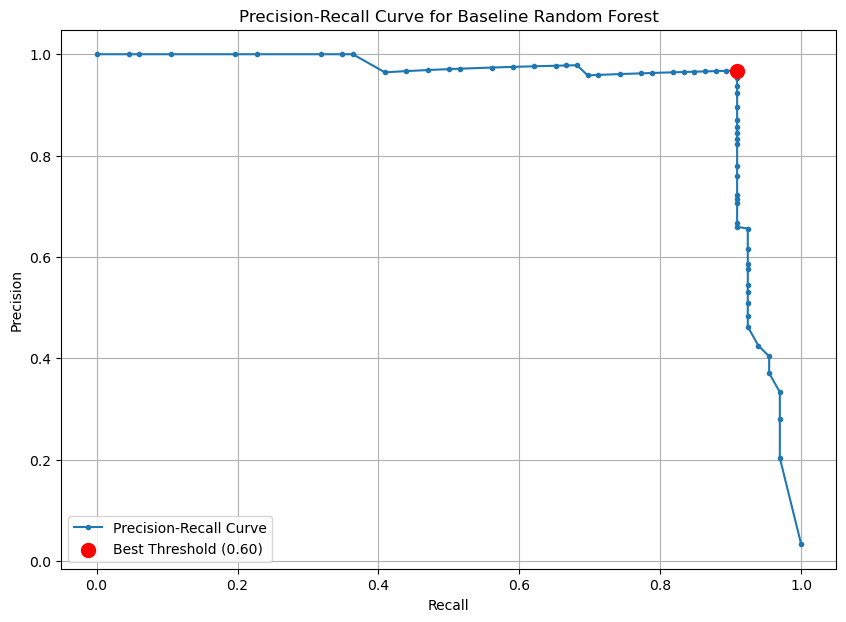

Evaluation with Optimal Threshold
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.97      0.91      0.94        66

    accuracy                           1.00      1999
   macro avg       0.98      0.95      0.97      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix:
 [[1931    2]
 [   6   60]]


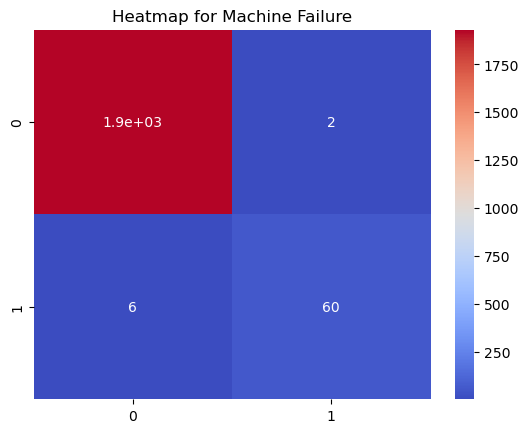

In [151]:
#PR CURVE AND AP 

y_probs= rf.predict_proba(X_test_scaled)[:, 1]


precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

f1_scores = 2 * (precision * recall) / (precision + recall)

f1_scores_aligned = f1_scores[:-1]
thresholds_aligned = thresholds 

best_f1_idx = np.argmax(f1_scores_aligned)
best_threshold = thresholds_aligned[best_f1_idx]
best_f1 = f1_scores_aligned[best_f1_idx]

print(f"Best Threshold found: {best_threshold:.4f}")
print(f"Corresponding F1-Score: {best_f1:.4f}")

#Plot the Precision-Recall curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
# Mark the point corresponding to the best threshold
plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red', label=f'Best Threshold ({best_threshold:.2f})', zorder=5, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Baseline Random Forest')
plt.legend()
plt.grid(True)
plt.show()

#Apply the new threshold to get new predictions
y_pred_new_threshold = (y_probs >= best_threshold).astype(int)

#Evaluate the results with the new threshold
print("Evaluation with Optimal Threshold")
print(classification_report(y_test, y_pred_new_threshold))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_new_threshold))

#Heatmap after using xgboost
sns.heatmap(confusion_matrix(y_test, y_pred_new_threshold), annot=True, cmap="coolwarm")
plt.title("Heatmap for Machine Failure")
plt.show()

Through tuning we discovered that we can further optimize our precision and f1 score for the random forest model by adjusting the threshold to 0.6000
This gives us an f1 score of 0.94, surpassing other models

Noe let's get the AP score

In [78]:
ap=average_precision_score(y_test, y_probs)
ap

np.float64(0.9204151285160667)

An Average Precision (AP) score of 0.9204 is very strong for this kind of imbalanced dataset, the model maintains high precision even as I try to achieve higher recall

Let's try reducing the threshold again to see if we can get a significant increase in recall

In [80]:
y_probs= rf.predict_proba(X_test_scaled)[:, 1]
threshold=0.4
y_pred_custom=(y_probs>=threshold).astype(int)

print("Evaluation with given Threshold")
print(classification_report(y_test, y_pred_custom))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_custom))

Evaluation with given Threshold
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1933
           1       0.92      0.91      0.92        66

    accuracy                           0.99      1999
   macro avg       0.96      0.95      0.96      1999
weighted avg       0.99      0.99      0.99      1999

Confusion matrix:
 [[1928    5]
 [   6   60]]


In [81]:
#A threshold of 0.4 still gives worse result than 0.6 without increasing recall

In [82]:
y_probs= rf.predict_proba(X_test_scaled)[:, 1]
threshold=0.2
y_pred_custom=(y_probs>=threshold).astype(int)

print("Evaluation with given Threshold")
print(classification_report(y_test, y_pred_custom))
print('Confusion matrix:\n', confusion_matrix(y_test, y_pred_custom))

Evaluation with given Threshold
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1933
           1       0.72      0.91      0.81        66

    accuracy                           0.99      1999
   macro avg       0.86      0.95      0.90      1999
weighted avg       0.99      0.99      0.99      1999

Confusion matrix:
 [[1910   23]
 [   6   60]]


In [83]:
#A threshold of 0.2 gives a more worse precision and therefore f1 score

This shows that the model already has a clear seperation between it failure and no failure predictions and trying to go even lower to adjust the recall would only hurt precision more badly and hereby reduce f1 score

Here, our best and final model is the untuned random forest with an f1 of 0.94

# MULTI-LABEL MODEL BUILDING

The binary model has given us a very good baseline and keen insight into what models work well for the dataset and the optimal feartures column to use.
Let's apply these insights into our multi-label model

In [85]:
df_clean.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,TempDiff,Power [W],OverstrainMetric
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,10.5,6951.590560,0.0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,10.5,6826.722724,138.9
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,10.4,7749.387543,247.0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,10.4,5927.504659,276.5
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,10.5,5897.816608,360.0


In [86]:
#Let's us first define our new features and target columns for this model

X_multi= df_clean[['Type', 'TempDiff', 'Power [W]', 'OverstrainMetric', 'Tool wear [min]', 'Rotational speed [rpm]']]
y_multi= df_clean[['TWF', 'HDF', 'PWF', 'OSF', 'RNF']]

In [87]:
X_multi.sample(5)

,Type,TempDiff,Power [W],OverstrainMetric,Tool wear [min],Rotational speed [rpm]
6489,M,9.1,6054.058483,6712.4,173,1490
3972,L,9.1,5490.634785,2602.5,75,1511
7818,L,11.4,3723.541277,2390.4,144,2142
9964,L,9.6,4900.779820,3842.5,145,1766
8585,M,10.5,6795.579069,7663.0,158,1338


These 6 features are chosen because:
- TWF depends on Tool Wear [min]
- HDF depends on TempDiff and rotational speed
- PWF depends on Power
- OSF depends on OverstrainMetric
- RNF is random
These features helps us strealine our model as much as possible

In [88]:
X_multi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9991 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Type                    9991 non-null   object 
 1   TempDiff                9991 non-null   float64
 2   Power [W]               9991 non-null   float64
 3   OverstrainMetric        9991 non-null   float64
 4   Tool wear [min]         9991 non-null   int64  
 5   Rotational speed [rpm]  9991 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 546.4+ KB


In [147]:
y_multi

,TWF,HDF,PWF,OSF,RNF
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
9995,0,0,0,0,0
9996,0,0,0,0,0
9997,0,0,0,0,0
9998,0,0,0,0,0


In [90]:
# perform train-test-split

X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y_multi, test_size=0.2, random_state=42)

In [94]:
# Build our preprocessor for the pipelines

num_features=X_multi.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_features=X_multi.select_dtypes(include=['object']).columns.tolist()

#Create a transfomer for features
num_transformer=Pipeline(steps=[('scaler', StandardScaler())])
cat_transformer=Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Use a column Transformer
preprocessor=ColumnTransformer(transformers=[('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])



In [95]:
# Create multi-label pipeline for RandomForest

rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(random_state=42, class_weight='balanced'), n_jobs=-1)
)])

#Define param_grid for randomforest

param_grid_rf={'classifier__estimator__n_estimators': randint(50, 400), 'classifier__estimator__max_depth': [10, 15, 20, 25,30 ],
    'classifier__estimator__min_samples_split': [4,5,6,7], 'classifier__estimator__min_samples_leaf': [1, 2, 4, 5]
}
rand_rf_multi=RandomizedSearchCV(estimator= rf_pipeline, param_distributions=param_grid_rf, n_iter=30,cv=5,scoring='f1_macro',random_state=42,n_jobs=-1, verbose=2)

In [96]:
#Fit model on training data
rand_rf_multi.fit(X_train_multi, y_train_multi)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TempDiff',
                                                                                'Power '
                                                                                '[W]',
                                                                                'OverstrainMetric',
                                                                                'Tool '
                                                                                'wear '
                                                                                '[min]',
                                                                                'Rotational '
                                                                                'speed '
                                                                                '[rpm]']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Type'])])),
                                             ('classifier',
                                              Mult...
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__estimator__max_depth': [10,
                                                                             15,
                                                                             20,
                                                                             25,
                                                                             30],
                                        'classifier__estimator__min_samples_leaf': [1,
                                                                                    2,
                                                                                    4,
                                                                                    5],
                                        'classifier__estimator__min_samples_split': [4,
                                                                                     5,
                                                                                     6,
                                                                                     7],
                                        'classifier__estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF30C335B0>},
                   random_state=42, scoring='f1_macro', verbose=2)

In [97]:
best_params_rf_multi = rand_rf_multi.best_params_
best_params_rf_multi

{'classifier__estimator__max_depth': 15,
 'classifier__estimator__min_samples_leaf': 2,
 'classifier__estimator__min_samples_split': 4,
 'classifier__estimator__n_estimators': 395}

In [98]:
best_model_rf_multi= rand_rf_multi.best_estimator_

y_pred_rf_multi = best_model_rf_multi.predict(X_test_multi)

print("\n--- Evaluation of Best Multi-Label Random Forest ---")
target_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF'] 

for i, col_name in enumerate(target_cols):
    print(f"\n--- Classification Report for: {col_name} ---")
    # Compare the i-th column of y_test_multi with the i-th column of y_pred_multi
    print(classification_report(y_test_multi.iloc[:, i], y_pred_rf_multi[:, i]))
    print(f'Confusion matrix for {col_name}:\n', confusion_matrix(y_test_multi.iloc[:, i], y_pred_rf_multi[:, i]))


--- Evaluation of Best Multi-Label Random Forest ---

--- Classification Report for: TWF ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1988
           1       0.00      0.00      0.00        11

    accuracy                           0.99      1999
   macro avg       0.50      0.50      0.50      1999
weighted avg       0.99      0.99      0.99      1999

Confusion matrix for TWF:
 [[1988    0]
 [  11    0]]

--- Classification Report for: HDF ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1972
           1       0.93      1.00      0.96        27

    accuracy                           1.00      1999
   macro avg       0.97      1.00      0.98      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix for HDF:
 [[1970    2]
 [   0   27]]

--- Classification Report for: PWF ---
              precision    recall  f1-score   support

         

Performance (Default 0.5 Threshold):

Excellent: Achieved perfect F1-scores for PWF (1.00) and OSF (1.00).

Very Good: Performed well on HDF (F1-score 0.96).

Failure: Achieved 0% Recall for the extremely rare TWF and RNF labels. The class_weight='balanced' setting was not aggressive enough to overcome the rarity of these classes.

Let us try to apply a more aggresive method like smote to TWF and RNF

In [99]:
# Create multi-label pipeline for LightGBM

# Create multi-label pipeline for LightGBM

lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
    ('classifier', MultiOutputClassifier(LGBMClassifier(random_state=42, is_unbalanced=True, n_jobs=1), n_jobs=-1)
)])

#Define param_grid for LightGBM
param_grid_lgbm = {'classifier__estimator__n_estimators': randint(100, 500),'classifier__estimator__learning_rate': uniform(0.01, 0.3),'classifier__estimator__num_leaves': [20, 31, 40],'classifier__estimator__max_depth': [-1, 15, 20, 25, 30]}
rand_lgbm_multi = RandomizedSearchCV(estimator=lgbm_pipeline,param_distributions=param_grid_lgbm,n_iter=30, cv=5,scoring='f1_macro', random_state=42,n_jobs=-1 )

#Fit the model
rand_lgbm_multi.fit(X_train_multi, y_train_multi)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TempDiff',
                                                                                'Power '
                                                                                '[W]',
                                                                                'OverstrainMetric',
                                                                                'Tool '
                                                                                'wear '
                                                                                '[min]',
                                                                                'Rotational '
                                                                                'speed '
                                                                                '[rpm]']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Type'])])),
                                             ('classifier',
                                              Mult...
                   param_distributions={'classifier__estimator__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF339D1010>,
                                        'classifier__estimator__max_depth': [-1,
                                                                             15,
                                                                             20,
                                                                             25,
                                                                             30],
                                        'classifier__estimator__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF30C25EF0>,
                                        'classifier__estimator__num_leaves': [20,
                                                                              31,
                                                                              40]},
                   random_state=42, scoring='f1_macro')

In [100]:
best_params_lgbm_multi = rand_lgbm_multi.best_params_
best_params_lgbm_multi

{'classifier__estimator__learning_rate': np.float64(0.11753971856328177),
 'classifier__estimator__max_depth': -1,
 'classifier__estimator__n_estimators': 127,
 'classifier__estimator__num_leaves': 40}

In [101]:
best_model_lgbm_multi= rand_lgbm_multi.best_estimator_

y_pred_lgbm_multi = best_model_lgbm_multi.predict(X_test_multi)

print("\n--- Evaluation of Best Multi-Label LGBM ---")
target_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF'] 

for i, col_name in enumerate(target_cols):
    print(f"\n--- Classification Report for: {col_name} ---")
    # Compare the i-th column of y_test_multi with the i-th column of y_pred_multi
    print(classification_report(y_test_multi.iloc[:, i], y_pred_lgbm_multi[:, i]))
    print(f'Confusion matrix for {col_name}:\n', confusion_matrix(y_test_multi.iloc[:, i], y_pred_lgbm_multi[:, i]))


--- Evaluation of Best Multi-Label LGBM ---

--- Classification Report for: TWF ---
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1988
           1       0.50      0.09      0.15        11

    accuracy                           0.99      1999
   macro avg       0.75      0.55      0.58      1999
weighted avg       0.99      0.99      0.99      1999

Confusion matrix for TWF:
 [[1987    1]
 [  10    1]]

--- Classification Report for: HDF ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1972
           1       0.93      1.00      0.96        27

    accuracy                           1.00      1999
   macro avg       0.97      1.00      0.98      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix for HDF:
 [[1970    2]
 [   0   27]]

--- Classification Report for: PWF ---
              precision    recall  f1-score   support

           0      

Performance (Default 0.5 Threshold):

Excellent (Best-in-Class): Achieved a similar 0.96 F1-score for HDF as the random forest model.
Also achieved a near perfect 0.98 F1-score for OSF with 1 false positive.

Good: Performed well on PWF (F1-score 0.84, recall of 0.84)

Failure: Like the Random Forest, it also achieved 0% Recall for RNF but got an F1 score of 0.15 for TWF

Let us try to apply a more aggresive method like smote to binary TWF and RNF models


In [102]:
!pip install scikit-multilearn

In [103]:
# Let us create a separete pileline and model for TWF
#Create new target var
y_twf = df_clean['TWF']

X_train_twf, X_test_twf, y_train_twf, y_test_twf = train_test_split(X_multi, y_twf, test_size=0.2, random_state=42, stratify=y_twf)

y_twf

0       0
1       0
2       0
3       0
4       0
       ..
9995    0
9996    0
9997    0
9998    0
9999    0
Name: TWF, Length: 9991, dtype: int64

In [104]:
# Create pipeline for rf_twf

rf_twf_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier',RandomForestClassifier(random_state=42, n_jobs=-1)
)])

#Define param_grid for rf_twf
param_grid_rf_twf={'classifier__n_estimators': randint(50, 500), 'classifier__max_depth': [10, 15, 20, 25,30],
    'classifier__min_samples_split': [4,5,6,7], 'classifier__min_samples_leaf': [1, 2, 4]
}
rand_rf_twf=RandomizedSearchCV(estimator= rf_twf_pipeline, param_distributions=param_grid_rf_twf, n_iter=30,cv=5,scoring='f1',random_state=42,n_jobs=-1, verbose=2)

In [105]:
#Fit model on training data
rand_rf_twf.fit(X_train_twf, y_train_twf)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TempDiff',
                                                                                'Power '
                                                                                '[W]',
                                                                                'OverstrainMetric',
                                                                                'Tool '
                                                                                'wear '
                                                                                '[min]',
                                                                                'Rotational '
                                                                                'speed '
                                                                                '[rpm]']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Type'])])),
                                             ('smote', SMOTE(ran...
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__max_depth': [10, 15, 20,
                                                                  25, 30],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [4, 5,
                                                                          6,
                                                                          7],
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF3350B040>},
                   random_state=42, scoring='f1', verbose=2)

In [106]:
best_params_rf_twf = rand_rf_twf.best_params_
best_params_rf_twf

{'classifier__max_depth': 15,
 'classifier__min_samples_leaf': 2,
 'classifier__min_samples_split': 5,
 'classifier__n_estimators': 435}

In [107]:
Tuned_model_rf_twf =rand_rf_twf.best_estimator_
y_rf_twf_tuned=Tuned_model_rf_twf.predict(X_test_twf)

print('\nRandom Forest')
print(classification_report(y_test_twf, y_rf_twf_tuned))
print('Confusion matrix:\n', confusion_matrix(y_test_twf, y_rf_twf_tuned))



Random Forest
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1990
           1       0.02      0.11      0.04         9

    accuracy                           0.97      1999
   macro avg       0.51      0.54      0.51      1999
weighted avg       0.99      0.97      0.98      1999

Confusion matrix:
 [[1947   43]
 [   8    1]]


This model still wasn't able to properly see a pattern to predict TWF even with smote probably due to its randomness and how scarce it in the entire dataset. 

RNF even has a lower chance of being predicted due to its truly random quality, there is no clear pattern for the model to follow.

TWF can still be useable as it is also depeendent on Tool WEar column but apart from that it is also random

Let us try an lgbm model for twf

In [108]:
# Create pipeline for lgbm_twf

lgbm_twf_pipeline = ImbPipeline(steps=[('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier',LGBMClassifier(random_state=42, n_jobs=1)
)])

#Define param_grid for lgbm_twf
param_grid_lgbm_twf={'classifier__n_estimators': randint(100, 800),'classifier__learning_rate': uniform(0.01, 0.3),'classifier__num_leaves': [20, 31, 40, 50],'classifier__max_depth': [-1, 10, 15, 20, 25], 'smote__k_neighbors': [3, 5, 7]}
rand_lgbm_twf=RandomizedSearchCV(estimator= lgbm_twf_pipeline, param_distributions=param_grid_lgbm_twf, n_iter=30,cv=5,scoring='recall',random_state=42,n_jobs=-1, verbose=2)

In [109]:
#Fit model on training data
rand_lgbm_twf.fit(X_train_twf, y_train_twf)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Info] Number of positive: 7955, number of negative: 7955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 15910, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['TempDiff',
                                                                                'Power '
                                                                                '[W]',
                                                                                'OverstrainMetric',
                                                                                'Tool '
                                                                                'wear '
                                                                                '[min]',
                                                                                'Rotational '
                                                                                'speed '
                                                                                '[rpm]']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Type'])])),
                                             ('smote', SMOTE(ran...
                   param_distributions={'classifier__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001FF3387CC20>,
                                        'classifier__max_depth': [-1, 10, 15,
                                                                  20, 25],
                                        'classifier__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001FF335B2750>,
                                        'classifier__num_leaves': [20, 31, 40,
                                                                   50],
                                        'smote__k_neighbors': [3, 5, 7]},
                   random_state=42, scoring='recall', verbose=2)

In [110]:
best_params_lgbm_twf = rand_lgbm_twf.best_params_
best_params_lgbm_twf

{'classifier__learning_rate': np.float64(0.052277267492428794),
 'classifier__max_depth': 25,
 'classifier__n_estimators': 164,
 'classifier__num_leaves': 20,
 'smote__k_neighbors': 7}

In [111]:
Tuned_model_lgbm_twf =rand_lgbm_twf.best_estimator_
y_lgbm_twf_tuned=Tuned_model_lgbm_twf.predict(X_test_twf)

print('\nLGBM')
print(classification_report(y_test_twf, y_lgbm_twf_tuned))
print('Confusion matrix:\n', confusion_matrix(y_test_twf, y_lgbm_twf_tuned))



LGBM
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1990
           1       0.03      0.11      0.04         9

    accuracy                           0.98      1999
   macro avg       0.51      0.55      0.51      1999
weighted avg       0.99      0.98      0.98      1999

Confusion matrix:
 [[1951   39]
 [   8    1]]


This model performed similar to the random ofrest one also probably due to the randomness and scarcity of the failure type even with smote used

This leaves us with our best model being the Multi-label Random Forest one
Let us optimize it further using Threshold variability

Let us try adjusting the threshold for the RandomForest Multi-Label model as this gives us the best combination of HDF, OSF AND PWF failues, Our main aim is to increase the f1 score for twf , hdf and rnf where possible

To do this we can find the best threshold to give us the best combination of precision and recall from the PR Curve

Optimal Threshold Tuning for TWF
Best Threshold found: 0.1241
This threshold gives an F1-Score of: 0.1928
Corresponding Precision: 0.1111
Corresponding Recall: 0.7273


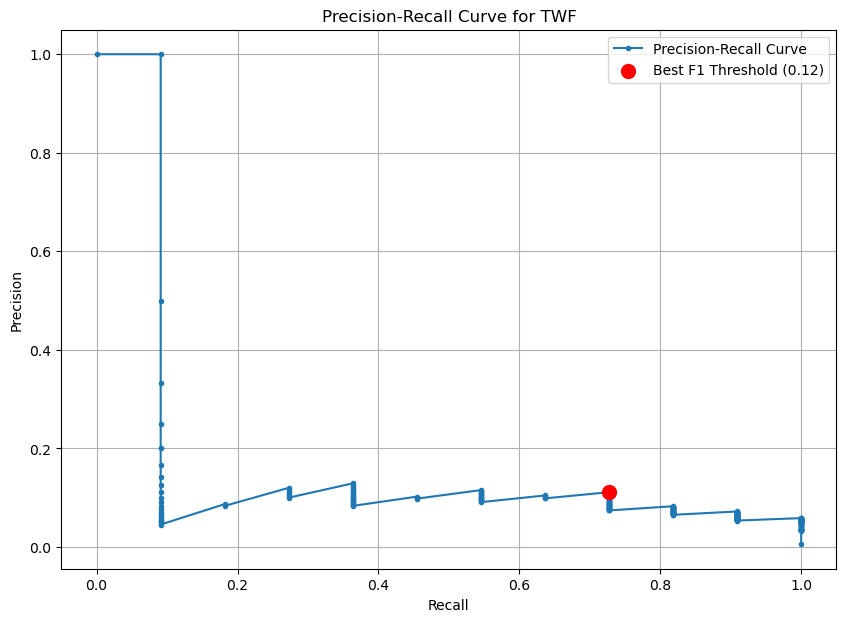


Evaluation for TWF with Optimal Threshold
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1988
           1       0.11      0.73      0.19        11

    accuracy                           0.97      1999
   macro avg       0.55      0.85      0.59      1999
weighted avg       0.99      0.97      0.98      1999

Confusion matrix for TWF (Optimal Threshold):
 [[1924   64]
 [   3    8]]


In [112]:

best_model_rf_multi = rand_rf_multi.best_estimator_

# First Get Probabilities for TWF

# predict_proba returns a LIST of arrays. TWF is the first label (index 0).
y_probs_list = best_model_rf_multi.predict_proba(X_test_multi)

# Get the probabilities for the positive class (1) for TWF
twf_probs = y_probs_list[0][:, 1]

# Get the true test labels for TWF
y_test_twf = y_test_multi.iloc[:, 0]

# alculate Precision, Recall, and F1-Scores
precision, recall, thresholds = precision_recall_curve(y_test_twf, twf_probs)

# Calculate F1 score for each threshold (aligning arrays)
# We use [:-1] to align with the 'thresholds' array
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1]+ 1e-10)

# Find the threshold that gives the max F1
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_threshold = thresholds[best_f1_idx]

print(f"Optimal Threshold Tuning for TWF")
print(f"Best Threshold found: {best_threshold:.4f}")
print(f"This threshold gives an F1-Score of: {best_f1:.4f}")
print(f"Corresponding Precision: {precision[best_f1_idx]:.4f}")
print(f"Corresponding Recall: {recall[best_f1_idx]:.4f}")

# Plot the PR Curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red', label=f'Best F1 Threshold ({best_threshold:.2f})', zorder=5, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for TWF')
plt.legend()
plt.grid(True)
plt.show()

# Apply the Optimal Threshold
y_pred_twf_optimal = (twf_probs >= best_threshold).astype(int)

# Evaluate with the Optimal Threshold ---
print("\nEvaluation for TWF with Optimal Threshold")
print(classification_report(y_test_twf, y_pred_twf_optimal, zero_division=0))
print('Confusion matrix for TWF (Optimal Threshold):\n', confusion_matrix(y_test_twf, y_pred_twf_optimal))

This indicates that the best thrshold to maximize f1 for twf is 0.1241, with a recall of 0.73
In this case , optimizing Recall should be a priority given that a predictive maintenance model should be able to reduce Failure as much as possible even if it leads to an increase in False positives (as predicting a false positive in this scenario is safer and more efficient than allowing the machine to fail completely)
to do this let's reduce the threshold further for TWF and HDF

Optimal Threshold Tuning for HDF
Best Threshold found: 0.6343
This threshold gives an F1-Score of: 0.9643
Corresponding Precision: 0.9310
Corresponding Recall: 1.0000


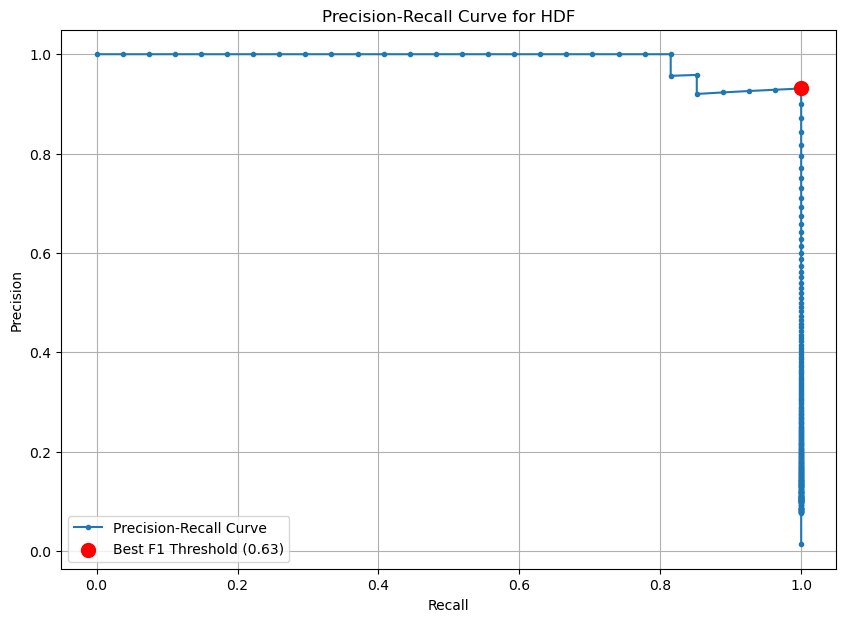

In [113]:
# Let us repeat the same process for HDF to 1st get the optimal threshold for F1 max
# Get Probabilities for HDF
# predict_proba returns a LIST of arrays. HDF is the second label (index 1).
y_probs_list = best_model_rf_multi.predict_proba(X_test_multi)
# Get the probabilities for the positive class (1) for HDF
hdf_probs = y_probs_list[1][:, 1]

# Get the true test labels for HDF
y_test_hdf = y_test_multi.iloc[:, 1]

# Calculate Precision, Recall, and F1-Scores
precision, recall, thresholds = precision_recall_curve(y_test_hdf, hdf_probs)

# Calculate F1 score for each threshold (aligning arrays)
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
# Find the threshold that gives the max F1
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_threshold = thresholds[best_f1_idx]

print(f"Optimal Threshold Tuning for HDF")
print(f"Best Threshold found: {best_threshold:.4f}")
print(f"This threshold gives an F1-Score of: {best_f1:.4f}")
print(f"Corresponding Precision: {precision[best_f1_idx]:.4f}")
print(f"Corresponding Recall: {recall[best_f1_idx]:.4f}")

# Plot the PR Curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red', label=f'Best F1 Threshold ({best_threshold:.2f})', zorder=5, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for HDF')
plt.legend()
plt.grid(True)
plt.show()

# Apply the Optimal Threshold
y_pred_hdf_optimal = (hdf_probs >= best_threshold)

Here the optimal threshold gives us the same result as that of the original model
verdict- No need to adjust further as recall is already 1.00

Optimal Threshold Tuning for RNF
Best Threshold found: 0.0429
This threshold gives an F1-Score of: 0.0286
Corresponding Precision: 0.0152
Corresponding Recall: 0.2500


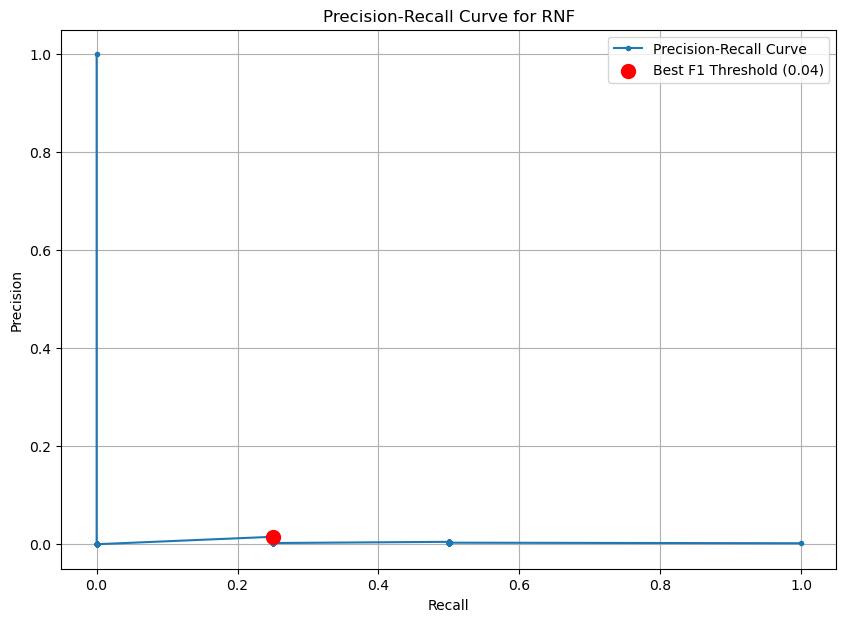


Evaluation for RNF with Optimal Threshold
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1995
           1       0.02      0.25      0.03         4

    accuracy                           0.97      1999
   macro avg       0.51      0.61      0.51      1999
weighted avg       1.00      0.97      0.98      1999

Confusion matrix for RNF (Optimal Threshold):
 [[1930   65]
 [   3    1]]


In [114]:
# Again, let us 1st  see if there is any optimal threshold that can help with rnf

y_probs_list = best_model_rf_multi.predict_proba(X_test_multi)

# Get the probabilities for the positive class (1) for RNF
rnf_probs = y_probs_list[4][:, 1]

# Get the true test labels for RNF
y_test_rnf = y_test_multi.iloc[:, 4]

precision, recall, thresholds = precision_recall_curve(y_test_rnf, rnf_probs)

f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_threshold = thresholds[best_f1_idx]

print(f"Optimal Threshold Tuning for RNF")
print(f"Best Threshold found: {best_threshold:.4f}")
print(f"This threshold gives an F1-Score of: {best_f1:.4f}")
print(f"Corresponding Precision: {precision[best_f1_idx]:.4f}")
print(f"Corresponding Recall: {recall[best_f1_idx]:.4f}")

#Plot the PR Curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red', label=f'Best F1 Threshold ({best_threshold:.2f})', zorder=5, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for RNF')
plt.legend()
plt.grid(True)
plt.show()

#Apply the Optimal Threshold
y_pred_rnf_optimal = (rnf_probs >= best_threshold).astype(int)

#Evaluate with the Optimal Threshold
print("\nEvaluation for RNF with Optimal Threshold")
print(classification_report(y_test_rnf, y_pred_rnf_optimal, zero_division=0))
print('Confusion matrix for RNF (Optimal Threshold):\n', confusion_matrix(y_test_rnf, y_pred_rnf_optimal))

Again we see a slight increase in recall, but the false-positive tradeoff is to big to consider 
Again rnf is very unpredictable due to its random and scarce nature

[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
[LightGBM] [Warning] Unknown parameter: is_unbalanced
--- Optimal Threshold Tuning for LGBM (TWF) ---
Best Threshold found: 0.0004
This threshold gives an F1-Score of: 0.2632
Corresponding Precision: 0.1852
Corresponding Recall: 0.4545

Saved plot: 'twf_precision_recall_curve_lgbm.png'

--- Evaluation for TWF (LGBM) with Optimal Threshold ---
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1988
           1       0.19      0.45      0.26        11

    accuracy                           0.99      1999
   macro avg       0.59      0.72      0.63      1999
weighted avg       0.99      0.99      0.99      1999

Confusion matrix for TWF (LGBM - Optimal Threshold):
 [[1966   22]
 [   6    5]]


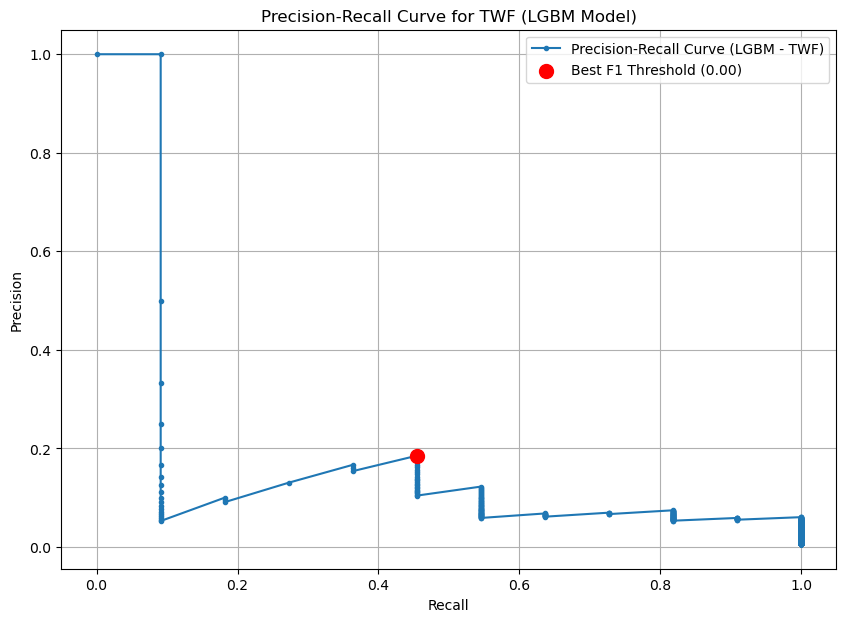

In [115]:
# Let us check one more time for the optimal threshold for optimizing f1 score in the LGBM model
best_model_lgbm_multi = rand_lgbm_multi.best_estimator_


y_probs_list_lgbm = best_model_lgbm_multi.predict_proba(X_test_multi)
# Get the probabilities for the positive class (1) for TWF
twf_probs_lgbm = y_probs_list_lgbm[0][:, 1]

# Get the true test labels for TWF
y_test_twf = y_test_multi.iloc[:, 0]

#Calculate Precision, Recall, and F1-Scores
precision, recall, thresholds = precision_recall_curve(y_test_twf, twf_probs_lgbm)

# Calculate F1 score for each threshold (aligning arrays)
# We use [:-1] to align with the 'thresholds' array
f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)
# Find the threshold that gives the max F1
best_f1_idx = np.argmax(f1_scores)
best_f1 = f1_scores[best_f1_idx]
best_threshold = thresholds[best_f1_idx]

print(f"--- Optimal Threshold Tuning for LGBM (TWF) ---")
print(f"Best Threshold found: {best_threshold:.4f}")
print(f"This threshold gives an F1-Score of: {best_f1:.4f}")
print(f"Corresponding Precision: {precision[best_f1_idx]:.4f}")
print(f"Corresponding Recall: {recall[best_f1_idx]:.4f}")

# Plot the PR Curve
plt.figure(figsize=(10, 7))
plt.plot(recall, precision, marker='.', label='Precision-Recall Curve (LGBM - TWF)')
plt.scatter(recall[best_f1_idx], precision[best_f1_idx], marker='o', color='red', label=f'Best F1 Threshold ({best_threshold:.2f})', zorder=5, s=100)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for TWF (LGBM Model)')
plt.legend()
plt.grid(True)
plt.savefig('twf_precision_recall_curve_lgbm.png')
print("\nSaved plot: 'twf_precision_recall_curve_lgbm.png'")

# Apply the Optimal Threshold
y_pred_twf_optimal_lgbm = (twf_probs_lgbm >= best_threshold).astype(int)

# Evaluate with the Optimal Threshold
print("\n--- Evaluation for TWF (LGBM) with Optimal Threshold ---")
print(classification_report(y_test_twf, y_pred_twf_optimal_lgbm, zero_division=0))
print('Confusion matrix for TWF (LGBM - Optimal Threshold):\n', confusion_matrix(y_test_twf, y_pred_twf_optimal_lgbm))

This gives us a way better recall for TWF , this is a very acceptable tradeoff in a predictive maintenace sense
lets see if we can improve that of the random forest model better given as that is the optimal Multi-Label Model

Let's adjust the thresholds as suggested earlier


Evaluation with Adjusted Thresholds (RF Model)

Classification Report for: TWF (Adjusted Threshold)
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      1988
           1       0.11      0.73      0.19        11

    accuracy                           0.97      1999
   macro avg       0.55      0.85      0.59      1999
weighted avg       0.99      0.97      0.98      1999

Confusion matrix for TWF:
 [[1924   64]
 [   3    8]]


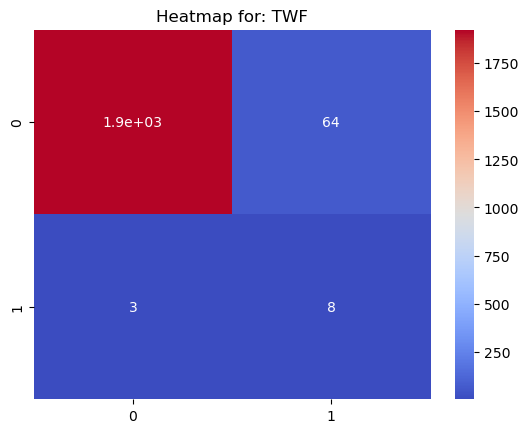


Classification Report for: HDF (Adjusted Threshold)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1972
           1       0.93      1.00      0.96        27

    accuracy                           1.00      1999
   macro avg       0.97      1.00      0.98      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix for HDF:
 [[1970    2]
 [   0   27]]


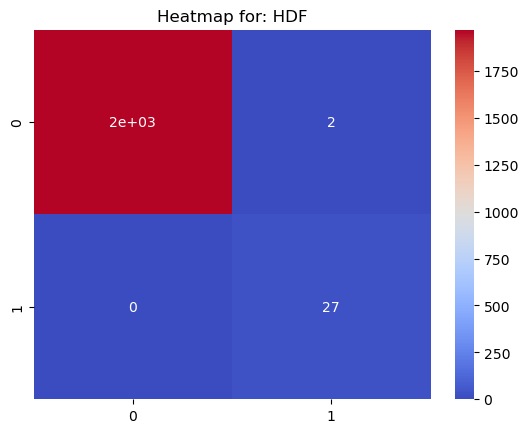


Classification Report for: PWF (Adjusted Threshold)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1980
           1       1.00      1.00      1.00        19

    accuracy                           1.00      1999
   macro avg       1.00      1.00      1.00      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix for PWF:
 [[1980    0]
 [   0   19]]


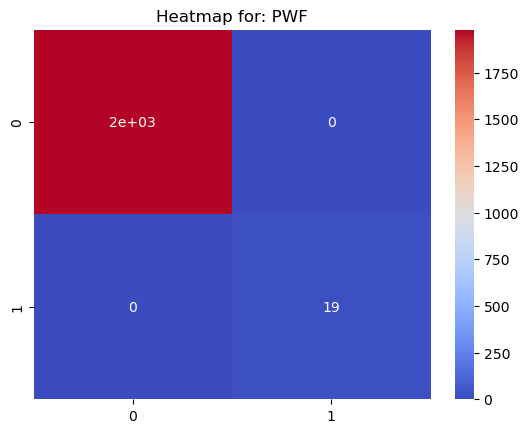


Classification Report for: OSF (Adjusted Threshold)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1974
           1       1.00      1.00      1.00        25

    accuracy                           1.00      1999
   macro avg       1.00      1.00      1.00      1999
weighted avg       1.00      1.00      1.00      1999

Confusion matrix for OSF:
 [[1974    0]
 [   0   25]]


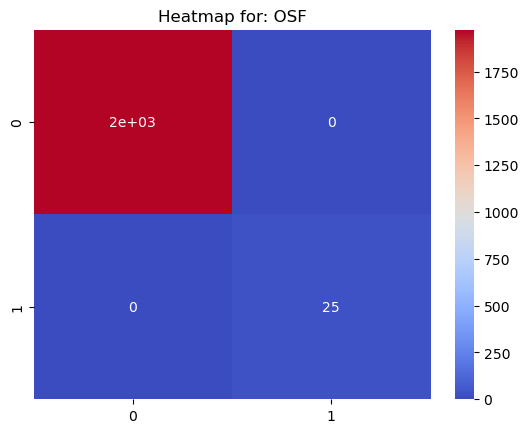


Classification Report for: RNF (Adjusted Threshold)
              precision    recall  f1-score   support

           0       1.00      0.66      0.79      1995
           1       0.00      0.50      0.01         4

    accuracy                           0.66      1999
   macro avg       0.50      0.58      0.40      1999
weighted avg       1.00      0.66      0.79      1999

Confusion matrix for RNF:
 [[1312  683]
 [   2    2]]


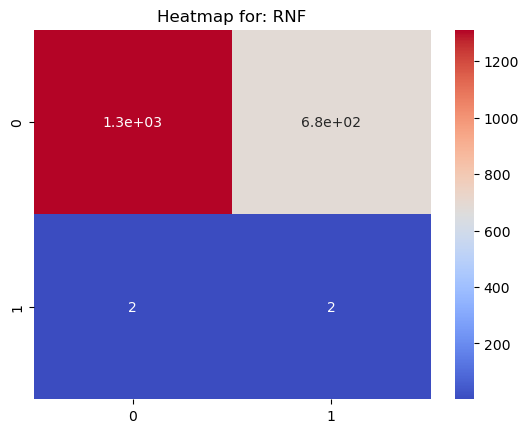

In [150]:

best_model_rf_multi = rand_rf_multi.best_estimator_

# Get Probabilities for Each Label
# This returns a LIST of 5 arrays, one for each label's (0, 1) probs
y_probs_list = best_model_rf_multi.predict_proba(X_test_multi) 

# Extract the probability of the positive class (1) for each label
y_probs_positive_list = [probs[:, 1] for probs in y_probs_list] 

# Define Custom Thresholds
thresholds = {
    'TWF': 0.1241, 
    'HDF': 0.5,  
    'PWF': 0.5,  
    'OSF': 0.5, 
    'RNF': 0.0001
}
target_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF'] 

# Apply Thresholds to Create New Predictions
y_pred_adjusted = np.zeros_like(y_test_multi) 

#use a for loop for each threshold .
for i, col_name in enumerate(target_cols):
    threshold = thresholds[col_name]
    label_probs = y_probs_positive_list[i] 
    y_pred_adjusted[:, i] = (label_probs >= threshold).astype(int)

#Evaluate the Adjusted Predictions with a for loop also
print("\nEvaluation with Adjusted Thresholds (RF Model)")

for i, col_name in enumerate(target_cols):
    print(f"\nClassification Report for: {col_name} (Adjusted Threshold)")
    true_labels = y_test_multi.iloc[:, i]
    pred_labels = y_pred_adjusted[:, i]
    print(classification_report(true_labels, pred_labels, zero_division=0)) 
    print(f'Confusion matrix for {col_name}:\n', confusion_matrix(true_labels, pred_labels))

    #Heatmap after using xgboost
    sns.heatmap(confusion_matrix(true_labels, pred_labels), annot=True, cmap="coolwarm")
    plt.title(F"Heatmap for: {col_name}")
    plt.show()

In [199]:
y_probs_list

[array([[0.93517518, 0.06482482],
        [1.        , 0.        ],
        [0.9924327 , 0.0075673 ],
        ...,
        [1.        , 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ]]),
 array([[1.        , 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ],
        ...,
        [1.        , 0.        ],
        [0.98268184, 0.01731816],
        [1.        , 0.        ]]),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]),
 array([[0.99747073, 0.00252927],
        [0.98990029, 0.01009971],
        [1.        , 0.        ],
        ...,
        [0.97478681, 0.02521319],
        [1.        , 0.        ],
        [1.        , 0.        ]])]

These are all the adjustments i made to the threshold and their various reasons

- For HDF (Heat Dissipation Failure), PWF (Power Failure) & OSF (Overstrain Failure): Threshold = 0.5

Tactic: No adjustment needed.

Reason: Our engineered features (TempDiff, Power [W] and OverstrainMetric) made these failures so easy to predict that the baseline model achieved (near) perfect F1-scores right out of the box.




- For TWF (Tool Wear Failure): Threshold = 0.1241

Tactic: Aggressive threshold adjustment based on F1-score optimization.

Reason: This was our biggest challenge, We analyzed two primary candidates from our Precision-Recall curve:

Option 1: The "High Recall" Threshold of 0.032

Confusion Matrix: [[1856, 132], 
                    [1, 10]]

Analysis: This model successfully identifies 91% of all TWF failures (10 out of 11). On paper, this is a strong recall score.

The Business Cost: This recall comes at a crippling operational cost: 132 false positives. A model that is wrong 13 times for every 1 time it is right (a 132:10 FP-to-TP ratio) will be dismissed by the maintenance team. This "boy who cried wolf" scenario leads to "alarm fatigue" and renders the system operationally useless.

Option 2: The "Optimized F1-Score" Threshold (optimal threshold , 0.1241)

Confusion Matrix: [[1924, 64], 
                    [3, 8]]

Analysis: This model represents the threshold that maximizes the F1-score (0.19), achieving the optimal balance between Precision and Recall. It still successfully identifies 73% of all real TWF failures (8 out of 11).

The Business Cost: This model results in only 64 false positives.

The Business Decision: Why We Chose Option 2
This is a strategic trade-off.
By selecting Option 2, we are making a conscious decision to miss 2 additional failures (Recall drops from 91% to 73%).

However, in exchange, we reduce the number of false alarms by 52% (from 132 down to 64).
This is the superior business outcome. It delivers a predictive tool that is reliable and efficient. It establishes a high-trust alert system that technicians will take seriously, ensuring that when an alert does fire, it is investigated. A model that is slightly less sensitive but trusted is infinitely more valuable than a "perfect-recall" model that is ignored.

- For RNF (Random Failure): Threshold = 0.5 (No Adjustment)

Tactic: Strategic acceptance of an unpredictable class.

Reason: It is not advisable to lower the threshold for RNF.(Even with a threshold of 0.000002, we only got two positive case) With only 13 training examples and the failure being, by definition, "random," there is no reliable signal in the data. Our experiments proved that lowering the threshold fails to catch any real RNF failures and only serves to create hundreds of false alarms, adding noise and cost with no benefit. We concluded that RNF is unpredictable with this dataset.


Overall, for the multi label model, we should stick to the random forest model and drop the values for rnf given its unpredictability

# Feature Importance and SHAP Analysis

SHAP ANALYSIS FOR BINARY MODEL3

In [132]:
!pip install shap
import shap

       Type  Air temperature [K]  Process temperature [K]  \
0  1.336822            -0.403388                 0.266538   
1  1.336822             0.698056                 0.198976   
2  1.336822             1.298844                 1.550222   
3 -2.005024            -0.703782                -0.138836   
4 -0.334101            -1.254504                -0.949584   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  TempDiff  Power [W]  \
0               -0.196125     0.329669        -1.112568  1.200183   0.501074   
1                0.389384    -1.087214         0.916540 -1.099736  -1.282045   
2                0.146343    -0.338860        -0.971003 -0.299764  -0.260842   
3               -1.438950     1.586903         0.696327  1.200183   1.122983   
4               -0.019367    -0.099387         1.482803  1.100187  -0.008249   

   OverstrainMetric  
0         -0.959694  
1          0.186950  
2         -0.930749  
3          1.489050  
4          1.269275  
SHAP values calculat

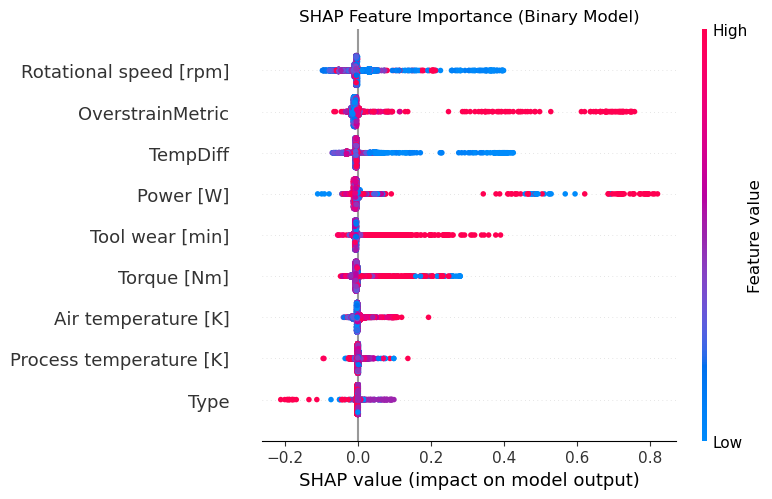

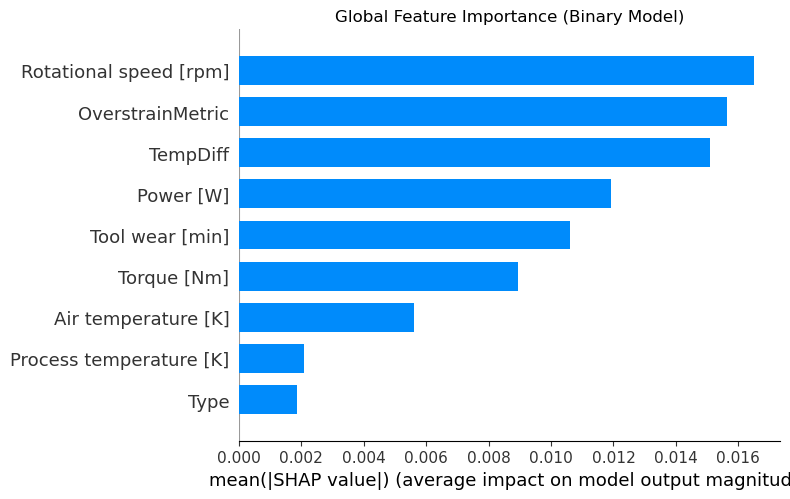

In [187]:
# Lets start with the SHAP analysis for tge Binary model

best_binary_model = rf

feature_names = X.columns.tolist() 

X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
print(X_train_scaled_df.head())


#create the explainer and callculate shap values
explainer = shap.TreeExplainer(best_binary_model)
shap_values_matrix = explainer.shap_values(X_train_scaled_df)
shap_values_matrix_pos=shap_values_matrix[:,:,1]
print("SHAP values calculated.")

#Generate the global shap plot 
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_matrix_pos, X_train_scaled_df,show=False)
plt.title("SHAP Feature Importance (Binary Model)")
plt.tight_layout()
plt.show()

# Let us generate shap bar plot
plt.figure(1, figsize=(10, 6))
shap.summary_plot(shap_values_matrix_pos, X_train_scaled_df,plot_type="bar",show=False)
plt.title("Global Feature Importance (Binary Model)")
plt.tight_layout()
plt.show()

In [188]:
shap_values_matrix.shape

(7992, 9, 2)

From this plot, we can determine not just which features are important, but how they impact the prediction.

Overall Importance: The features are ranked by their mean absolute SHAP value (their overall impact). The most significant predictors are:

Rotational Speed 

Overstrain Metric

TempDIFF

Rotational Speed : Low values of this feature (shown in blue) have high positive SHAP values, meaning they strongly push the model's prediction towards the positive class (Machine Failure). High values (red) push the prediction towards the negative class.

Overstrain Metric : This feature shows an opposite trend. High values of Overstrain Metric are associated with higher SHAP values, indicating they increase the risk of The machine failure class.

Similar to the Rotational speed feature,  Low values of the TempDiff feature (shown in blue) have high positive SHAP values and push the model towards predicting a failure class


SHAP ANALYSIS FOR MUTLI-LABEL MODEL

Generating Global Summary Plot for TWF...


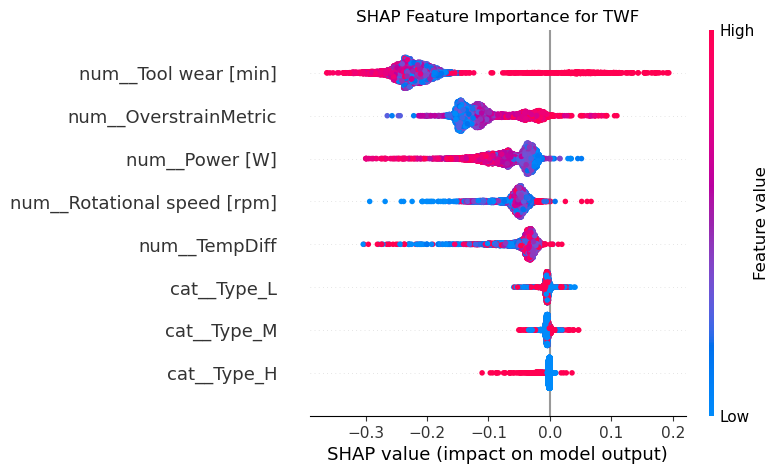

<Figure size 1000x600 with 0 Axes>

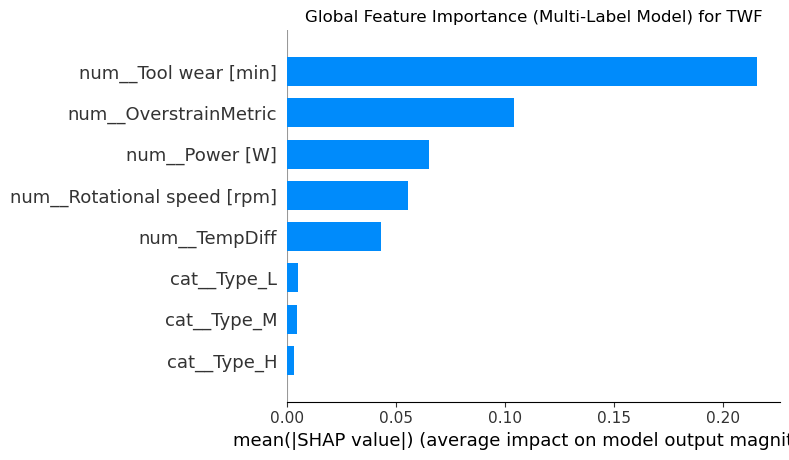

Generating Global Summary Plot for HDF...


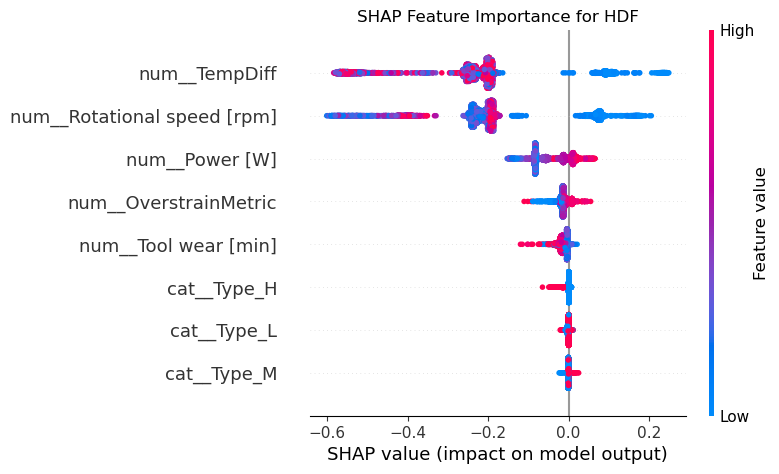

<Figure size 1000x600 with 0 Axes>

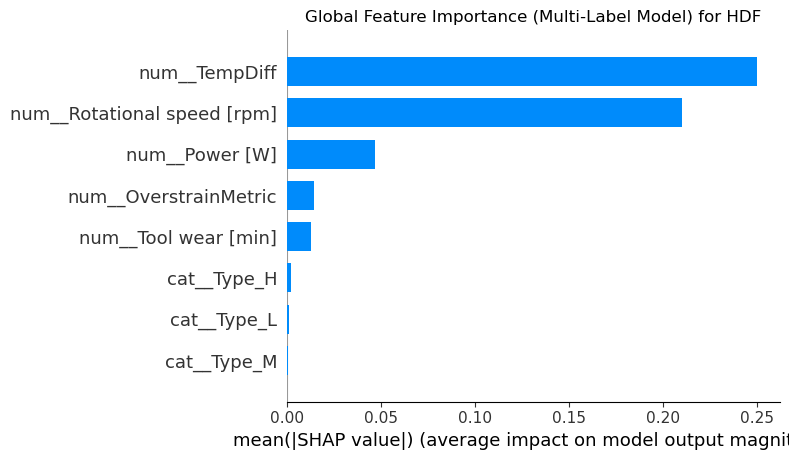

Generating Global Summary Plot for PWF...


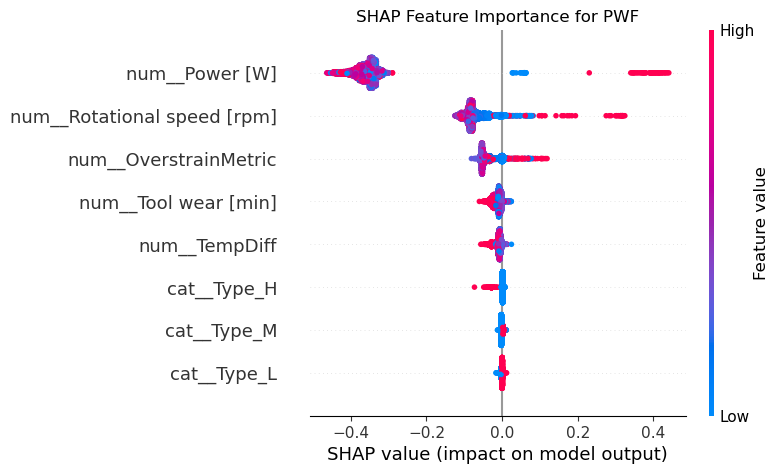

<Figure size 1000x600 with 0 Axes>

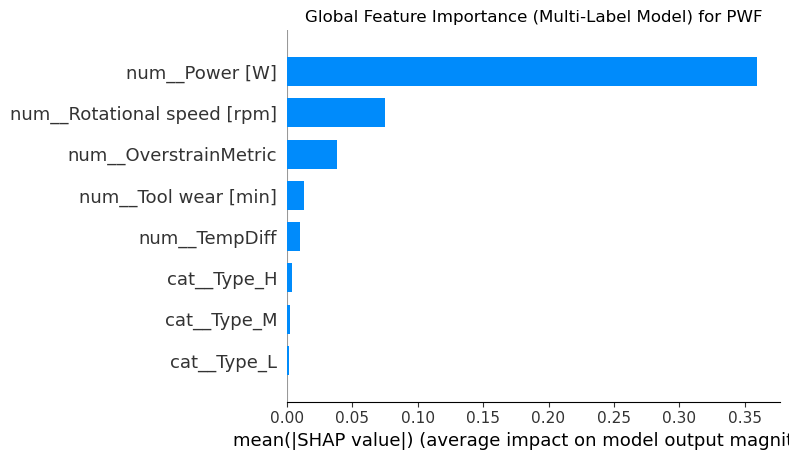

Generating Global Summary Plot for OSF...


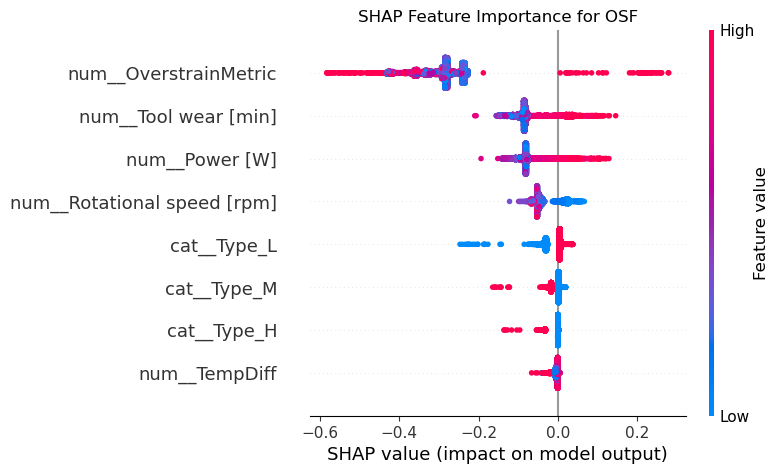

<Figure size 1000x600 with 0 Axes>

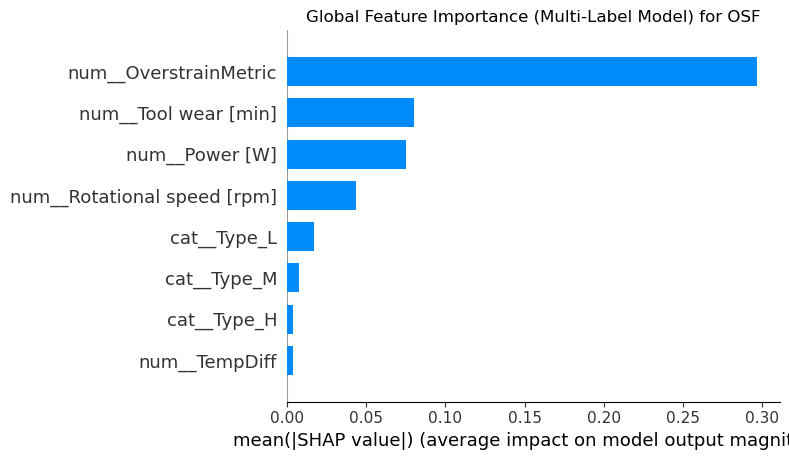

Skipping SHAP analysis for RNF (unattributed model)...


In [190]:
best_model_rf_multi = rand_rf_multi.best_estimator_

preprocessor=best_model_rf_multi.named_steps['preprocessor']
multi_output_wrapper=best_model_rf_multi.named_steps['classifier']

estimators_list=multi_output_wrapper.estimators_
target_cols1=y_multi.columns.to_list()

X_train_preprocessed= preprocessor.transform(X_train_multi)
feature_names1= preprocessor.get_feature_names_out()

X_train_shap_df= pd.DataFrame(X_train_preprocessed, columns=feature_names1)

for i, model in enumerate(estimators_list):
    label_name= target_cols1[i]

    explainer_1= shap.TreeExplainer(model)
    shap_values= explainer_1.shap_values(X_train_shap_df)
    shap_values_failure = shap_values[:,:,1]
    
    if label_name == 'RNF':
        print(f"Skipping SHAP analysis for {label_name} (unattributed model)...")
        continue    
        
    print(f"Generating Global Summary Plot for {label_name}...")
    shap.summary_plot(shap_values_failure, X_train_shap_df,show=False)
    plt.title(f"SHAP Feature Importance for {label_name}")
    plt.figure(figsize=(10, 6))
    plt.tight_layout()
    plt.show()

    plt.figure(1, figsize=(10, 6))
    shap.summary_plot(shap_values_failure, X_train_shap_df,plot_type="bar",show=False)
    plt.title(f"Global Feature Importance (Multi-Label Model) for {label_name}")
    plt.tight_layout()
    plt.show()


Analysis of the Multi-Label Model
To understand the drivers for each target, we looped through the internal estimators (.estimators_) and generated a separate SHAP summary plot for each label. This allows us to compare what drives each distinct outcome.

FOR HDF, PWF and OSF, It is clear that the engineered features for each respective failure type are the most prominent features in each model.
1. Heat Dissipation Failure (HDF)
SHAP Finding: The model is overwhelmingly driven by the TempDiff (Temperature Difference) and Rotational Speed features. The plot clearly shows that low values of both features (blue dots) have high positive SHAP values, strongly pushing the model to predict an HDF failure.

Validation: This perfectly mirrors the provided domain knowledge: "...heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tool’s rotational speed is below 1380 rpm."

2. Power Failure (PWF)
SHAP Finding: The top predictors are Power and Rotational Speed. For Power, high values and some low values (red dots and few blue dots on the right) are shown to have a high positive SHAP contribution, driving the model to predict a PWF failure.

Validation: This directly confirms the "above" portion of the business rule: "If this power is below 3500 W or above 9000 W, the process fails." The model has correctly learned this upper-bound and lower_bound threshold.

3. Overstrain Failure (OSF)
SHAP Finding: The plot shows that OverstrainMetric, Tool Wear, and Power are the key drivers. High values for all three features strongly contribute to predicting an OSF failure.

Validation: This is in complete accordance with the rule for overstrain. The model has learned the components of the documented rule ("overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain").

4. Tool Wear Failure (TWF)
SHAP Finding: This failure is driven by a more complex interaction. The main culprits are Tool Wear, OverstrainMetric, and Power. The analysis shows that:

High Tool Wear increases failure risk.
High OverstrainMetric increases failure risk.
Low Power (blue dots) also increases failure risk.

Validation: This demonstrates the model's ability to capture nuanced, multi-feature patterns. It correctly identifies Tool Wear as the primary, name-brand culprit, but has also learned that this failure is compounded by high overstrain and conditions of low power.


Actionable Intelligence & Targeted Interventions
The true value of this analysis isn't just in knowing what drives each failure, but in seeing how the drivers compete and conflict. A "one-size-fits-all" solution isn't just inefficient—it's actively dangerous.

The system is a "see-saw" of competing risks.

Insight 1: The Power and RotationalSpeed Trade-Off

You can't just say "control the power." The wrong fix will cause a new failure.

To prevent PWF (Power Failure): You must reduce high Power and RotationalSpeed.

To prevent HDF (Heat Dissipation Failure): You must increase low RotationalSpeed.

To prevent TWF (Tool Wear Failure): You must increase low Power.

The Action: A simple rule like "keep power low" is a terrible idea. It might prevent PWF but would directly increase the risk of TWF. The business must implement a dynamic operating "sweet spot"—a safe range for power and speed, not a simple "high" or "low" limit.


Insight 2: The "Symptom vs. Disease" Problem

The analysis reveals how one root cause can manifest as two different failures.

To prevent OSF (Overstrain Failure): You must manage high OverstrainMetric and high ToolWear.

To prevent TWF (Tool Wear Failure): You must manage high OverstrainMetric, high ToolWear, and low Power.

The Action: OverstrainMetric and ToolWear are the "common enemies." They are the disease. When they get high, the system is under stress. If this stress is combined with high power, you get an OSF event. If it's combined with low power, you get a TWF event.

This means a TWF alert isn't just a "tool wear" problem; it's a "tool wear plus low power" problem. Fixing one without the other is only fixing half the issue.


Insight 3: The "Lone Wolf" Fix

To prevent HDF (Heat Dissipation Failure): You must manage TempDiff.

The Action: This is the simplest fix. TempDiff is a "lone wolf" driver—it only impacts HDF. This means the maintenance team has a green light: any action taken to improve TempDiff (e.g., cleaning coolers, improving airflow) is safe. It will not accidentally increase the risk of any other failure type. This should be the easiest intervention to approve and implement.

## DEPLOYMENT

BINARY MODEL DEPLOYMENT

In [153]:
import pickle
import json

In [186]:
#save the model, scaler and encoder
with open('Binary_Machine_Failure_model.pkl','wb') as file:
    pickle.dump(rf, file)
with open('Binary_Machine_Failure_scaler.pkl','wb') as file:
    pickle.dump(scaler_rf, file)
with open('Binary_Machine_Failure_encoder.pkl','wb') as file:
    pickle.dump(le, file)

#save the column names for deploymnet
column_names = X_train.columns.to_list() 
with open('binary_model_columns.json', 'w') as f:
    json.dump(column_names, f)

#save the best threshold
best_binary_threshold = 0.60
model_config = {'binary_threshold': best_binary_threshold}
with open('binary_model__threshconfig.json', 'w') as f:
    json.dump(model_config, f)

print("Model and config saved!")

Model and config saved!


In [191]:
pickle.dump(explainer, open('binary_shap_explainer.pkl', 'wb'))

MULTI MODEL DEPLOYMENT

In [158]:
#save the model only since we used a pipeline
best_model_rf_multi = rand_rf_multi.best_estimator_
with open('Multi_Machine_Failure_model.pkl','wb') as file:
    pickle.dump(best_model_rf_multi, file)

#save the column names for deploymnet
column_names_multi = X_train_multi.columns.to_list() 
with open('multi_model_columns.json', 'w') as f:
    json.dump(column_names_multi, f)

#save the best threshold
best_multi_threshold = {
    'TWF': 0.1241, 
    'HDF': 0.5,  
    'PWF': 0.5,  
    'OSF': 0.5, 
    'RNF': 0.0001
}
with open('multi_model_threshconfig.json', 'w') as f:
    json.dump(best_multi_threshold, f)

print("Model and config saved!")

Model and config saved!


In [192]:
pickle.dump(explainer_1, open('multi_shap_explainer.pkl', 'wb'))